### Named Entity Recognition for Recipe Ingredient Extraction

In [294]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [239]:
from tensorflow.keras import Model, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [189]:
recipes = pd.read_csv(os.path.join('data', 'cleaned_recipes.csv'))

In [190]:
recipes.drop(columns=['Unnamed: 0'], inplace=True)

In [191]:
recipes

,Ingredients,Directions
0,"butter,yeast,flour,egg,sugar,water,salt","Dissolve yeast in warm water.**Stir in sugar, ..."
1,"butter,baking powder,milk,orange juice,vanilla...",'Preheat oven to 350 degrees F (175 degrees C)...
2,"sour cream,baking powder,flour,egg,sugar,cinna...",Preheat oven to 350 degrees F (175 degrees C)....
3,"baking powder,milk,oat,flour,egg,baking soda,c...",Preheat oven to 350 degrees F (175 degrees C)....
4,"baking powder,buttermilk,oat,flour,egg,baking ...",Mix oats with buttermilk. Let stand for 1/2 h...
5,"yeast,milk,flour,egg,sugar,shortening,fruit,salt",Cream shortening and sugar together. Stir in ...
6,"brown sugar,yeast,shortening,water,salt,bread,...",Dissolve brown sugar in 1 cup hot water. Add ...
7,flour,Add the ingredients to the pan of your bread m...
8,"baking powder,margarine,vanilla,flour,banana,e...",Preheat oven to 350 degrees F (175 degrees C)....
9,"pimento,milk,pepper,bell pepper,egg,cornmeal,g...",Preheat oven to 350 degrees F (175 degrees C)....


### Data preprocessing

In [192]:
def input_preprocessing(recipe):
    recipe = recipe.lower()
    # remove numbers
    recipe = re.sub('\d+', '', recipe)
    # remove special symbols
    recipe = re.sub('[^a-zA-z\s]', '', recipe)
    # remove single characters
    recipe = re.sub(' . |.- | -.', ' ', recipe)
    # replace multiple spaces by just one space
    recipe = re.sub(' +', ' ', recipe)
    recipe = re.sub(' $', '', recipe)
    
    return recipe

In [193]:
def ingredient_preprocessing(ingredients):
    ingredients = ingredients.lower()
    ingredients = re.sub('\d+', '', ingredients)
    ingredients = re.sub('[^a-zA-z\s,]', '', ingredients)
    
    return ingredients

In [194]:
recipes.Directions = recipes.Directions.apply(lambda e: input_preprocessing(e))

In [195]:
recipes.Ingredients = recipes.Ingredients.apply(lambda i: ingredient_preprocessing(i))

### Map each word from the recipes to an index

In [196]:
t = Tokenizer()
t.fit_on_texts(list(recipes.Directions))

In [295]:
# Save tokenizer for inference phase
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [197]:
vocab_size = len(t.word_index)
encoded_recipes = t.texts_to_sequences(list(recipes.Directions))

In [230]:
max_len_recipe = max([len(r) for r in encoded_recipes])

In [231]:
max_len_recipe

490

In [243]:
print('Number of unique words is:', vocab_size)

Number of unique words is: 13696


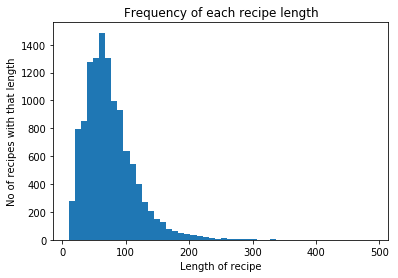

In [201]:
# We observe that most of the recipes have between 0 and 100 words
plt.hist([len(r) for r in encoded_recipes], bins=50)
plt.title('Frequency of each recipe length')
plt.xlabel('Length of recipe')
plt.ylabel('No of recipes with that length')
plt.show()

### Each word from the recipe will be tagged as ingredient (1) or not ingredient (2)

In [278]:
def tag_recipe(recipe, ingredients):
    recipe_words = re.split(' ', recipe)
    tagged_recipe = []
    
    for w in recipe_words:
        if any([i for i in ingredients if i in w]):
            tagged_recipe.append(1)
        else:
            tagged_recipe.append(0)
    
    return tagged_recipe

In [279]:
encoded_tags = []

for i, r in recipes.iterrows():
    encoded_tags.append(tag_recipe(r['Directions'], r['Ingredients'].split(',')))
    
    assert len(encoded_tags[-1]) == len(encoded_recipes[i])

### Prepare data for training and testing

In [271]:
encoded_recipes = [(np.array(e) - 1).tolist() for e in encoded_recipes]

In [283]:
X = pad_sequences(maxlen=max_len_recipe, sequences=encoded_recipes, padding="post", value=vocab_size-1)
y = pad_sequences(maxlen=max_len_recipe, sequences=encoded_tags, padding="post", value=0)

In [214]:
X

array([[  486,   536,     3, ..., 13696, 13696, 13696],
       [   31,    12,     4, ..., 13696, 13696, 13696],
       [   31,    12,     4, ..., 13696, 13696, 13696],
       ...,
       [   31,    12,     4, ..., 13696, 13696, 13696],
       [   31,    12,     4, ..., 13696, 13696, 13696],
       [   31,    12,     4, ..., 13696, 13696, 13696]])

In [215]:
y

array([[2, 1, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [284]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [285]:
len(x_train)

9565

In [286]:
len(x_test)

2392

### Build and train a Bi-LSTM model

In [287]:
input_recipe = Input(shape=(max_len_recipe,))
model = Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len_recipe)(input_recipe)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = Dense(2, activation="softmax")(model)

In [288]:
model = Model(input_recipe, out)

In [289]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 490)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 490, 100)          1369600   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 490, 100)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 490, 200)          160800    
_________________________________________________________________
dense_6 (Dense)              (None, 490, 2)            402       
Total params: 1,530,802
Trainable params: 1,530,802
Non-trainable params: 0
_________________________________________________________________


In [290]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [291]:
ckpt = ModelCheckpoint("models/model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [ckpt, early_stopping]

In [292]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/3
299/299 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9895
Epoch 00001: val_loss improved from inf to 0.01177, saving model to models/model_weights.h5
299/299 [==============================] - 744s 2s/step - loss: 0.0394 - accuracy: 0.9895 - val_loss: 0.0118 - val_accuracy: 0.9954
Epoch 2/3
299/299 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9957
Epoch 00002: val_loss improved from 0.01177 to 0.01030, saving model to models/model_weights.h5
299/299 [==============================] - 819s 3s/step - loss: 0.0107 - accuracy: 0.9957 - val_loss: 0.0103 - val_accuracy: 0.9959
Epoch 3/3
299/299 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9964
Epoch 00003: val_loss improved from 0.01030 to 0.00953, saving model to models/model_weights.h5
299/299 [==============================] - 855s 3s/step - loss: 0.0093 - accuracy: 0.9964 - val_loss: 0.0095 - val_accuracy: 0.9965


In [293]:
model.save('models/model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/model\assets


In [296]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [303]:
model.evaluate(x_test, y_test)

75/75 [==============================] - 41s 550ms/step - loss: 0.0095 - accuracy: 0.9965


[0.009532571770250797, 0.9964507818222046]

### Plot model performance

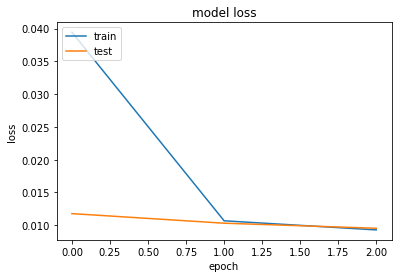

In [301]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

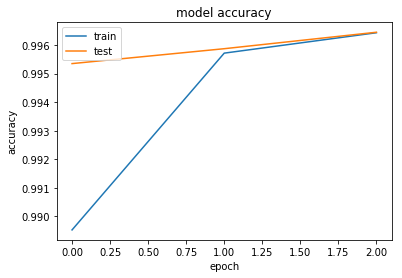

In [302]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()